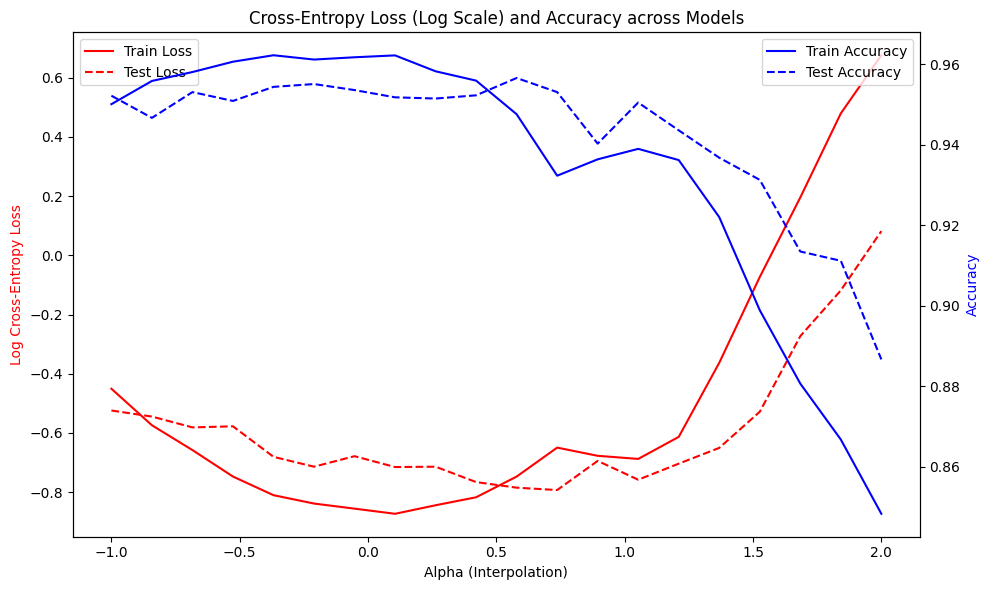

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load MNIST dataset
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='C:\\Users\\lokes\\OneDrive\\Desktop\\deep', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='C:\\Users\\lokes\\OneDrive\\Desktop\\deep', train=False, download=True, transform=transform)

# Define batch sizes
batch_sizes = [64, 1024]
train_loader_small = DataLoader(train_data, batch_size=batch_sizes[0], shuffle=True)
test_loader_small = DataLoader(test_data, batch_size=batch_sizes[0], shuffle=True)
train_loader_large = DataLoader(train_data, batch_size=batch_sizes[1], shuffle=True)
test_loader_large = DataLoader(test_data, batch_size=batch_sizes[1], shuffle=True)

# Function to calculate the number of parameters in the model
def calc_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, in_features=784, hidden1=20, hidden2=40, out_features=10):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.out = nn.Linear(hidden2, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for X_train, y_train in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_train.view(-1, 784))
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(y_pred.data, 1)
            correct_train += (predicted == y_train).sum().item()
            total_train += y_train.size(0)
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct_train / total_train)

        # Evaluation
        model.eval()
        running_test_loss = 0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for X_test, y_test in test_loader:
                y_val = model(X_test.view(-1, 784))
                loss = criterion(y_val, y_test)
                running_test_loss += loss.item()

                _, predicted = torch.max(y_val.data, 1)
                correct_test += (predicted == y_test).sum().item()
                total_test += y_test.size(0)

        test_losses.append(running_test_loss / len(test_loader))
        test_accuracies.append(correct_test / total_test)

    return train_losses, test_losses, train_accuracies, test_accuracies

# Model 1: Batch size 64, learning rate 0.01
model_small = SimpleNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_small.parameters(), lr=0.01)
train_loss_small, test_loss_small, train_acc_small, test_acc_small = train_and_evaluate(model_small, train_loader_small, test_loader_small, criterion, optimizer)

# Model 2: Batch size 1024, learning rate 0.01
model_large = SimpleNN()
criterion_large = nn.CrossEntropyLoss()
optimizer_large = torch.optim.Adam(model_large.parameters(), lr=0.01)
train_loss_large, test_loss_large, train_acc_large, test_acc_large = train_and_evaluate(model_large, train_loader_large, test_loader_large, criterion_large, optimizer_large)

# Linear interpolation between the parameters of model1 and model2
def interpolate_models(model1, model2, alpha):
    interpolated_model = SimpleNN()
    with torch.no_grad():
        for param1, param2, param_interpolated in zip(model1.parameters(), model2.parameters(), interpolated_model.parameters()):
            param_interpolated.copy_((1 - alpha) * param1 + alpha * param2)
    return interpolated_model

# Interpolation parameters and plotting
alpha_vals = np.linspace(-1.0, 2.0, num=20)
interp_train_losses, interp_test_losses = [], []
interp_train_accuracies, interp_test_accuracies = [], []

# Iterate over interpolation factors
for alpha in alpha_vals:
    interpolated_model = interpolate_models(model_small, model_large, alpha)
    optimizer_interp = torch.optim.Adam(interpolated_model.parameters(), lr=0.01)

    train_loss, test_loss, train_acc, test_acc = train_and_evaluate(interpolated_model, train_loader_small, test_loader_small, criterion, optimizer_interp, epochs=1)

    interp_train_losses.append(train_loss[0])
    interp_test_losses.append(test_loss[0])
    interp_train_accuracies.append(train_acc[0])
    interp_test_accuracies.append(test_acc[0])

# Updated plotting of results to match the screenshot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot cross-entropy loss (log scale)
ax1.plot(alpha_vals, np.log10(interp_train_losses), 'r-', label='Train Loss')
ax1.plot(alpha_vals, np.log10(interp_test_losses), 'r--', label='Test Loss')

# Create a second y-axis for accuracy
ax2 = ax1.twinx()

# Plot accuracy
ax2.plot(alpha_vals, interp_train_accuracies, 'b-', label='Train Accuracy')
ax2.plot(alpha_vals, interp_test_accuracies, 'b--', label='Test Accuracy')

# Labeling and formatting
ax1.set_xlabel('Alpha (Interpolation)')
ax1.set_ylabel('Log Cross-Entropy Loss', color='r')
ax2.set_ylabel('Accuracy', color='b')
ax1.set_title('Cross-Entropy Loss (Log Scale) and Accuracy across Models')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()
